In [ ]:
%pip install numpy pandas tqdm scikit-learn matplotlib seaborn ucimlrepo

In [1]:
# from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# steel_industry_energy_consumption = fetch_ucirepo(id=851) 

df = pd.read_csv('datasets/Steel_Industry_data.csv')
X = df.drop(columns=['Usage_kWh', 'date']).copy()
y = df['Usage_kWh']
  
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
X['Day_of_week'] = X['Day_of_week'].map(day_mapping)
X['Day_sin'] = np.sin(2 * np.pi * X['Day_of_week'] / 7)
X['Day_cos'] = np.cos(2 * np.pi * X['Day_of_week'] / 7)
X = pd.get_dummies(X, columns=['WeekStatus', 'Load_Type'])  

In [2]:
X

,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Day_of_week,Day_sin,Day_cos,WeekStatus_Weekday,WeekStatus_Weekend,Load_Type_Light_Load,Load_Type_Maximum_Load,Load_Type_Medium_Load
0,2.95,0.00,0.0,73.21,100.00,900,0,0.0,1.0,True,False,True,False,False
1,4.46,0.00,0.0,66.77,100.00,1800,0,0.0,1.0,True,False,True,False,False
2,3.28,0.00,0.0,70.28,100.00,2700,0,0.0,1.0,True,False,True,False,False
3,3.56,0.00,0.0,68.09,100.00,3600,0,0.0,1.0,True,False,True,False,False
4,4.50,0.00,0.0,64.72,100.00,4500,0,0.0,1.0,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,4.86,0.00,0.0,62.10,100.00,82800,0,0.0,1.0,True,False,True,False,False
35036,3.74,0.00,0.0,70.71,100.00,83700,0,0.0,1.0,True,False,True,False,False
35037,3.17,0.07,0.0,76.62,99.98,84600,0,0.0,1.0,True,False,True,False,False
35038,3.06,0.11,0.0,77.72,99.96,85500,0,0.0,1.0,True,False,True,False,False


In [3]:
y

0        3.17
1        4.00
2        3.24
3        3.31
4        3.82
         ... 
35035    3.85
35036    3.74
35037    3.78
35038    3.78
35039    3.67
Name: Usage_kWh, Length: 35040, dtype: float64

In [4]:
X_all = X.to_numpy(dtype=np.float32)
y_all = y.to_numpy(dtype=np.float32)

In [5]:
(X_all.shape, y_all.shape)

((35040, 14), (35040,))

In [6]:
from sklearn.preprocessing import StandardScaler

split_idx = int(0.8 * len(X_all))

X_train = X_all[:split_idx]
X_test = X_all[split_idx:]
y_train = y_all[:split_idx]
y_test = y_all[split_idx:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()



In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w1 = nn.Linear(hidden_size, hidden_size)
        self.w2 = nn.Linear(input_size, hidden_size)
        self.w3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hx = None):
        x = torch.tensor(x)
        seq_size, _ = x.shape
        if hx is None:
            hx = torch.zeros((self.hidden_size))
        h_t = hx.clone()
        outputs = []
        for i in range(seq_size):
            h_t = torch.tanh(self.w1(h_t) + self.w2(x[i,:]))
            outputs.append(self.w3(h_t))
        outputs = torch.stack(outputs)
        return outputs, h_t



In [8]:
criterion = nn.MSELoss()
rnn = RNN(X_train.shape[1], 128, 1)
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.01)
batch_size = 32

100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


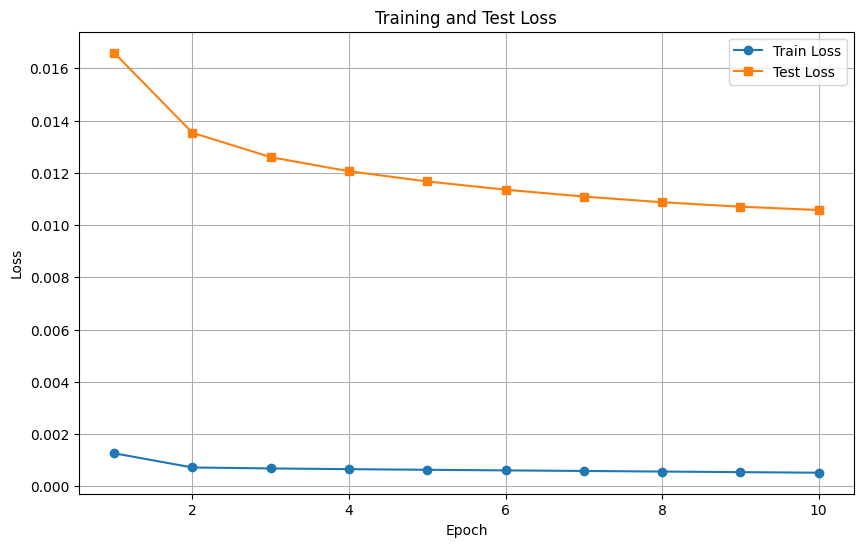

In [13]:
import matplotlib.pyplot as plt

train_losses = []
test_losses = []

for epoch in tqdm(range(10)):
    total_loss = 0
    count = 0
    for batch_idx in range(len(X_train) // batch_size):
        batch = X_train[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        targets = torch.tensor(y_train[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(batch_size, 1))
        outputs, hidden = rnn(batch)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += len(batch)
    train_losses.append(total_loss / count)

    test_loss = 0
    test_count = 0
    for batch_idx in range(len(X_test) // batch_size):
        batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        targets = torch.tensor(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
        outputs, hidden = rnn.forward(batch)
        test_loss += torch.sum((outputs - targets) ** 2).item()
        test_count += len(batch)
    test_losses.append(test_loss / test_count)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


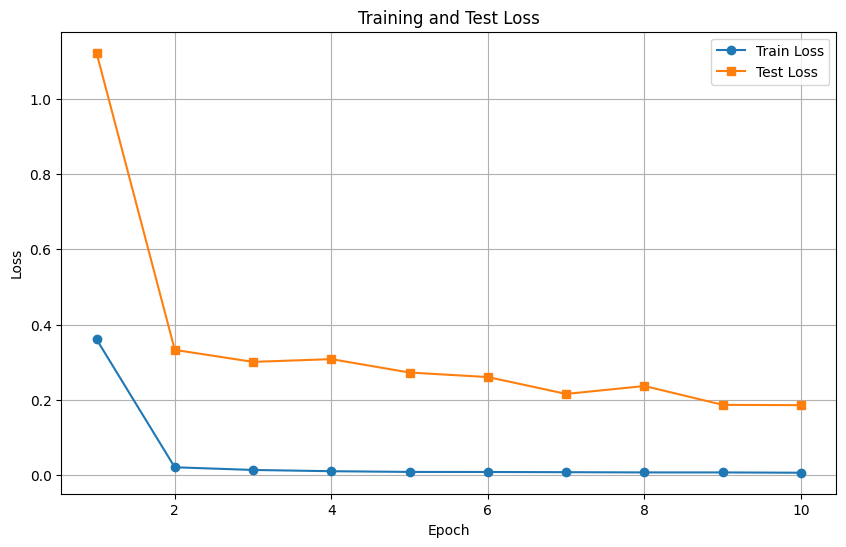

In [13]:
from source.rnn import RNN as RNN_numpy
import numpy as np
import matplotlib.pyplot as plt

rnn = RNN_numpy(input_size=X_train.shape[1], hidden_size=128, output_size=1, lr=0.001)

train_losses = []
test_losses = []

for epoch in tqdm(range(10)):
    epoch_loss = 0
    count = 0
    
    for i in range(0, len(X_train), batch_size):
        batch_x = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size].reshape(-1, 1)
        loss = rnn.backward(batch_x, batch_y)
        epoch_loss += loss
        count += len(batch_x)
    
    train_losses.append(epoch_loss / count)

    test_loss = 0
    test_count = 0
    for batch_idx in range(len(X_test) // batch_size):
        batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
        outputs, hidden = rnn.forward(batch)
        test_loss += np.sum((outputs - targets) ** 2)
        test_count += len(batch)
    
    test_losses.append(test_loss / test_count)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
mse_loss = 0
for batch_idx in range(len(X_test) // batch_size):
    batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
    outputs, hidden = rnn.forward(batch)
    mse_loss += np.sum((outputs - targets) ** 2)

print("Total MSE Loss on test set:", mse_loss)

Total MSE Loss on test set: 1300.416201621068


100%|██████████| 10/10 [00:41<00:00,  4.14s/it]


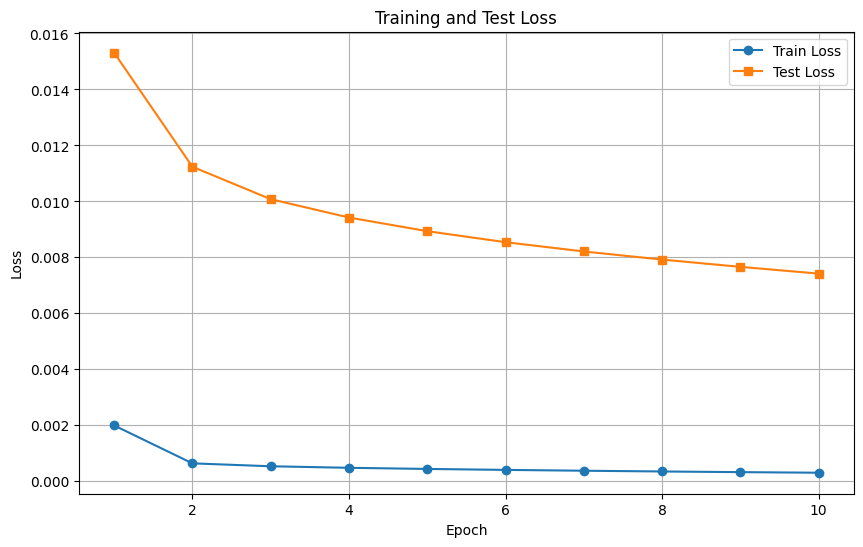

In [20]:
from source.lstm import LSTM as LSTM_numpy
import numpy as np
import matplotlib.pyplot as plt

lstm = LSTM_numpy(input_size=X_train.shape[1], hidden_size=128, output_size=1, lr=0.001)

train_losses = []
test_losses = []

for epoch in tqdm(range(10)):
    epoch_loss = 0
    count = 0
    
    for i in range(0, len(X_train), batch_size):
        batch_x = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size].reshape(-1, 1)
        loss = lstm.backward(batch_x, batch_y)
        epoch_loss += loss
        count += len(batch_x)
    
    train_losses.append(epoch_loss / count)

    test_loss = 0
    test_count = 0
    for batch_idx in range(len(X_test) // batch_size):
        batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
        outputs, hidden = lstm.forward(batch)
        test_loss += np.sum((outputs - targets) ** 2)
        test_count += len(batch)
    
    test_losses.append(test_loss / test_count)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
mse_loss = 0
for batch_idx in range(len(X_test) // batch_size):
    batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
    outputs, hidden = lstm.forward(batch)
    mse_loss += np.sum((outputs - targets) ** 2)

print("Total MSE Loss on test set:", mse_loss)

Total MSE Loss on test set: 52.000154959906574


100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


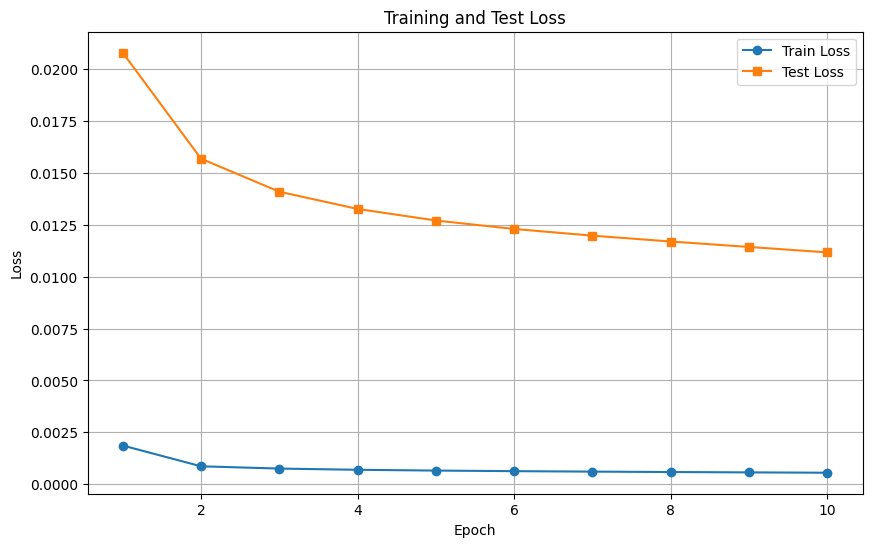

In [11]:
from source.gru import GRU as GRU_numpy
import numpy as np
import matplotlib.pyplot as plt

gru = GRU_numpy(input_size=X_train.shape[1], hidden_size=128, output_size=1, lr=0.001)

train_losses = []
test_losses = []

for epoch in tqdm(range(10)):
    epoch_loss = 0
    count = 0
    
    for i in range(0, len(X_train), batch_size):
        batch_x = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size].reshape(-1, 1)
        loss = gru.backward(batch_x, batch_y)
        epoch_loss += loss
        count += len(batch_x)
    
    train_losses.append(epoch_loss / count)

    test_loss = 0
    test_count = 0
    for batch_idx in range(len(X_test) // batch_size):
        batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
        outputs, hidden = gru.forward(batch)
        test_loss += np.sum((outputs - targets) ** 2)
        test_count += len(batch)
    
    test_losses.append(test_loss / test_count)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
mse_loss = 0
for batch_idx in range(len(X_test) // batch_size):
    batch = X_test[batch_idx * batch_size : (batch_idx + 1) * batch_size]
    targets = np.array(y_test[batch_idx * batch_size : (batch_idx + 1) * batch_size].reshape(1, batch_size, 1))
    outputs, hidden = gru.forward(batch)
    mse_loss += np.sum((outputs - targets) ** 2)

print("Total MSE Loss on test set:", mse_loss)

Total MSE Loss on test set: 78.30294598019375
